# Nengo Tutorial
We're going to be running through how to set up Nengo networks, how to simulate them, and some of the more common issues that you might run into when using Nengo! The goal of this is to set everyone up with a Minimum Effort Model that they can manipulate as well as to introduce how to set up learning in a Nengo model.

## Dependencies
For ease of typing, we're going to import some of the more common Nengo datatypes so that we don't need to write `nengo.<datatype>` repeatedly. We'll also be using matplotlib for visualization and the requests and csv libraries for handling the data.

So far, we have been looking to estimate the accelerations in $x$ and $y$ directions through an input spike train. Our model will move forward with that as a goal. As a black-box, you can consider the model to:
1. Take a spike train as an input, and
2. Produce an estimate of the acceleration of the end-effector (the monkey's paw in this case).

In [2]:
import requests
import csv
import numpy as np
import nengo
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

## Input Data
Since we're using the recorded spike-train as our input, we'll be extracting it from a csv file hosted on Google Drive. This is the easiest way that I know of where the file does not need to be downloaded locally.

In [3]:
# Electrode Data URL
snippet_url = "https://drive.google.com/uc?export=download&id=1FZSPZNdLWAGy0LWYVj0oNn47FC1Y3Mso"

# Dataset Info
max_timestamp = -1.0
dt = 0.001
dti = 1/dt

# Access CSV containing snippet of electrode data
electrode_dataset = []
with requests.get(snippet_url, stream=True) as r:
    lines = (line.decode('utf-8') for line in r.iter_lines())
    for row in csv.reader(lines):
        electrode_dataset += [[float(e_val) for e_val in row]]
        row_max = max(electrode_dataset[-1])
        max_timestamp = row_max if row_max > max_timestamp else max_timestamp

# Create Time-Stamp array
t = np.arange(0, np.ceil(max_timestamp*dti)/dti,dt)
spikes = np.zeros((len(electrode_dataset), len(t)))
for i, electrode_timings in enumerate(electrode_dataset):
    spikes[i,:], _ = np.histogram(np.array(electrode_dataset[i]), t.shape[0], [0, max_timestamp])
spikes = spikes * dti

### Spike Trains
For Nengo, spike trains should be input as a timeseries with a value of 1/dt where a spike occurs and 0 elsewhere. We can visualize the spike train using matplotlib's scatter functionality.

Text(0.5, 0, 'Time [s]')

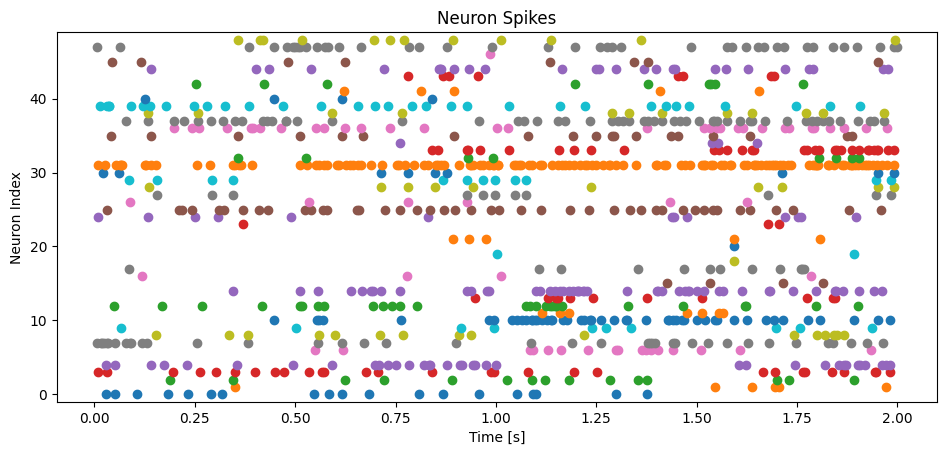

In [49]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
for r_i in range(spikes.shape[0]):
    pl.scatter(np.arange(0,plot_window/1000.0,0.001)[spikes[r_i,:plot_window] > 0.5], (((r_i)/1000)*spikes[r_i,:plot_window])[spikes[r_i,:plot_window] > 0.5]);
pl.set_ylim((-1,49)) # Adjust height to fit number of neurons explicitly
pl.set_title("Neuron Spikes")
pl.set_ylabel("Neuron Index")
pl.set_xlabel("Time [s]")

To introduce the spikes to Nengo, we can use a Node as follows:

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


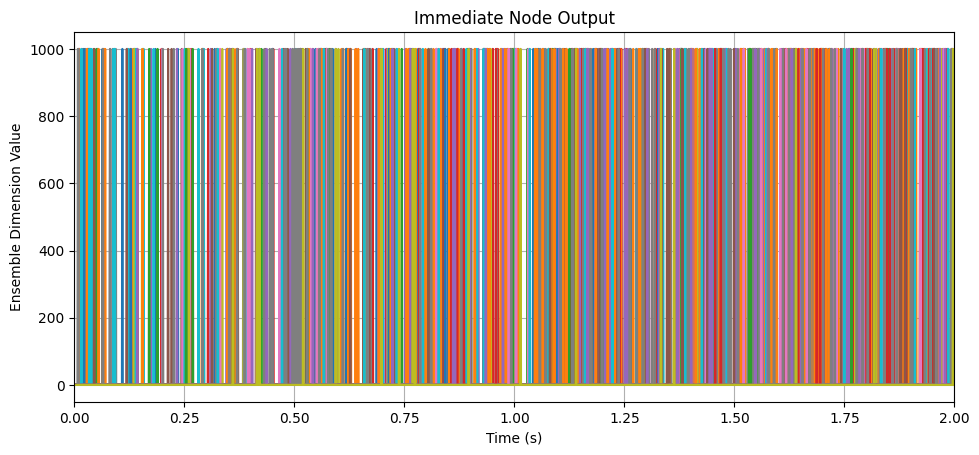

In [58]:
# Nengo Network Using Recorded Spikes as Input
np.random.seed(0)
with nengo.Network() as model:
    node_in = Node(lambda t: spikes[:,int(t / dt) - 1])
    p_in_pure = nengo.Probe(node_in, synapse=0)

with nengo.Simulator(model, seed=0) as sim:
    sim.run(2)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_in_pure]);
pl.set_title("Immediate Node Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.grid()

Nengo `Connections` implement synapse effects as long as the synapse constant is non-zero. By default, the synapse value is 0.01. We can observe the effects of this by passing the input node into another node through a connection.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


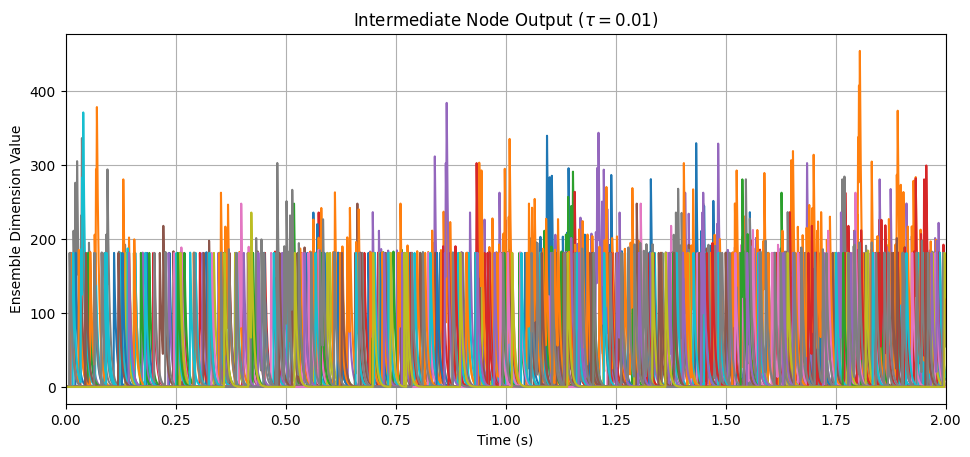

In [68]:
with model:
    node_inter = Node(size_in=spikes.shape[0])
    filt_con = Connection(node_in, node_inter)
    p_in = nengo.Probe(node_inter, synapse=0)
    
with nengo.Simulator(model, seed=0) as sim:
    sim.run(2)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_in]);
pl.set_title("Intermediate Node Output ($\\tau=0.01$)")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.grid()

Since our data is fairly sparse, we may want a better setup that allows the signal to stack a little more. We can accomplish this by increasing the syanptic time constant.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


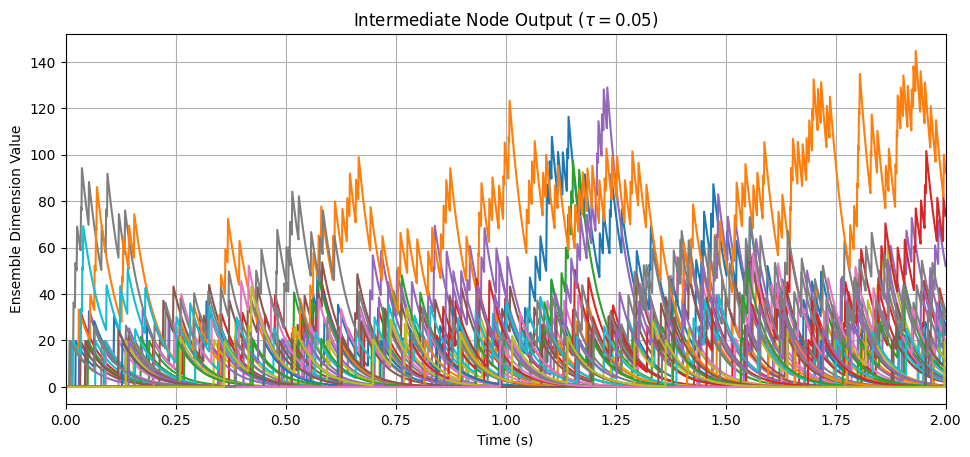

In [82]:
with model:
    filt_con.synapse = 0.05
    
with nengo.Simulator(model, seed=0) as sim:
    sim.run(2)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_in]);
pl.set_title("Intermediate Node Output ($\\tau=0.05$)")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.grid()

One thing worth noting is how the simulation and results reset everytime we call `nengo.Simulator(model)`. The Nengo Simulator object is responsible for building and running the model, so every time this object is instantiated, it clears the existing value in the `sim` variable. Now, let's make some fake acceleration profiles to test some stuff out!

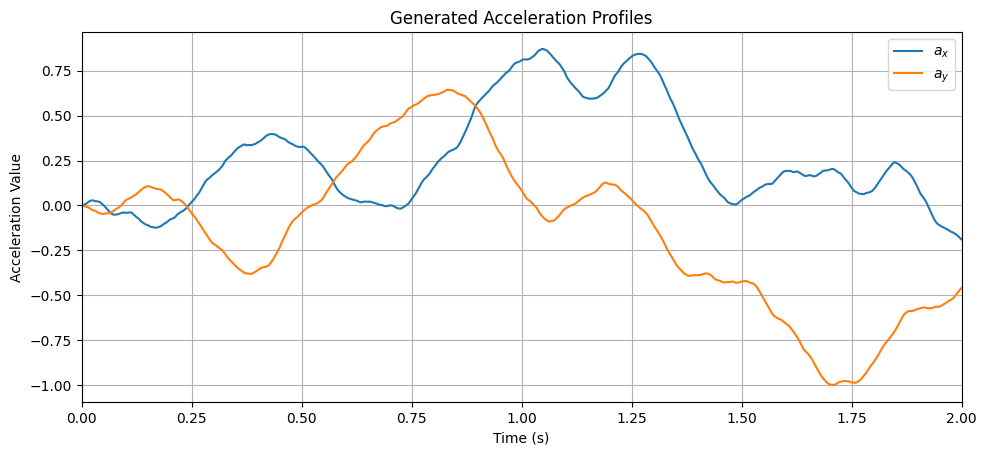

In [100]:
# Use band-limited noise  generation to generate a smooth-ish acceleration profile
fake_accel_gen = nengo.processes.FilteredNoise(synapse=nengo.synapses.Alpha(0.2))
fake_ax = fake_accel_gen.run(2.0, rng=np.random.RandomState(seed=0))
fake_ay = fake_accel_gen.run(2.0, rng=np.random.RandomState(seed=2))
fake_ts = fake_accel_gen.trange(2.0)

# Shrink both axes, maintain ratio
fake_ax = fake_ax / np.max(np.max([np.abs(fake_ax), np.abs(fake_ay)]))
fake_ay = fake_ay / np.max(np.max([np.abs(fake_ax), np.abs(fake_ay)]))

# Visualize
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(fake_ts, fake_ax, label="$a_x$");
pl.plot(fake_ts, fake_ay, label="$a_y$");
pl.set_title("Generated Acceleration Profiles")
pl.set_xlim((0,np.max(fake_ts)))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Acceleration Value")
pl.legend()
pl.grid()

## Decoder Calculation
We can calculate the "optimal" decoders using least-squares regression to calculate the pseudoinverse of the activity matrix (with some noise, of course)

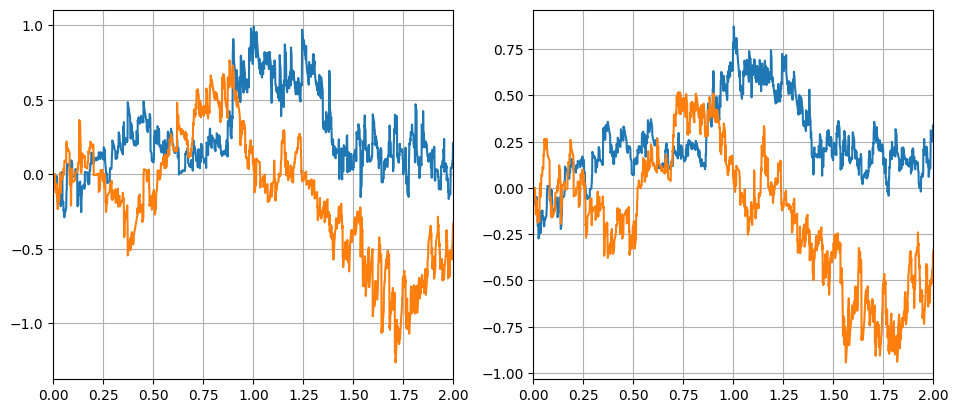

In [129]:
# Copy and move around data for calculations
A = sim.data[p_in].T
X = np.concatenate((fake_ax, fake_ay), 1).T

# Calculate Decoders
D = np.linalg.lstsq(A.T, X.T, rcond=None)[0]
D_reg = np.linalg.lstsq(A @ A.T + 2000 * np.square(np.random.normal(0,0.2*A.max(),1)) * np.eye(49), A @ X.T, rcond=None)[0]
X_hat = A.T @ D
X_hat_reg = A.T @ D_reg

# Visualize
fig, (pl1, pl2) = plt.subplots(1, 2)
fig.subplots_adjust(right=1.5)
pl1.plot(fake_ts, X_hat);
pl2.plot(fake_ts, X_hat_reg);
pl1.set_xlim((0,np.max(fake_ts)))
pl2.set_xlim((0,np.max(fake_ts)))
pl1.grid()
pl2.grid()